In [49]:
%pip install librosa

Defaulting to user installation because normal site-packages is not writeable
  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached soundfile-0.11.0-py2.py3-none-macosx_10_9_x86_64.macosx_11_0_x86_64.whl (1.2 MB)
  Using cached audioread-3.0.0.tar.gz (377 kB)
  Preparing metadata (setup.py) ... done
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 5.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.5/25.5 MB 6.0 MB/s eta 0:00:0000:0100:01
  Created wheel for audioread: filename=audioread-3.0.0-py3-none-any.whl size=23693 sha256=ec7cf04fb25332d48826d9a7a803b3b1876fcb8ba9b6707874aff6ed9e9a7889
  Stored in directory: /Users/yevheniyavytruchenko/Library/Caches/pip/wheels/74/25/48/ad94b69151b78e9aeba6850da119f04eda1c811d22fcf4b32d
Successfully built audioread
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from IPython.display import Audio

In [2]:
audio_file_paths = []
emotions = []
for root, dirs, files in os.walk('./Ravdess/'):
    for file in files:
        audio_path = os.path.join(root, file)
        audio_file_paths.append(audio_path)
        emotion = file.split('-')
        emotion = emotion[2]
        emotions.append(emotion)


path_df = pd.DataFrame(audio_file_paths, columns=['Path'])
emotions_df = pd.DataFrame(emotions, columns=['Emotion'])
Ravdess_df = pd.concat([emotions_df, path_df], axis=1)
Ravdess_df.Emotion.replace({'01':'neutral', '02':'calm', '03':'happy', '04':'sad', '05':'angry', '06':'fear', '07':'disgust', '08':'surprise'}, inplace=True)
Ravdess_df


,Emotion,Path
0,angry,./Ravdess/Actor_16/03-01-05-01-02-01-16.wav
1,fear,./Ravdess/Actor_16/03-01-06-01-02-02-16.wav
2,fear,./Ravdess/Actor_16/03-01-06-02-01-02-16.wav
3,angry,./Ravdess/Actor_16/03-01-05-02-01-01-16.wav
4,disgust,./Ravdess/Actor_16/03-01-07-01-01-01-16.wav
...,...,...
2875,happy,./Ravdess/Actor_08/03-01-03-02-02-02-08.wav
2876,happy,./Ravdess/Actor_08/03-01-03-01-01-02-08.wav
2877,calm,./Ravdess/Actor_08/03-01-02-02-01-01-08.wav
2878,calm,./Ravdess/Actor_08/03-01-02-01-02-01-08.wav


In [3]:
data_df = Ravdess_df

Gameplan:

1. Dataframe with filepath and emotion
2. Create waveplots
3. Create spectograms
4. Add data augmentation

5. Analyzing following features:
    - Zero Crossing Rate
    - Chroma_stft
    - MFCC
    - RMS(root mean square) value
    - MelSpectogram to train our model.



Here is the filename identifiers as per the official RAVDESS website:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


<AxesSubplot: xlabel='Emotion'>

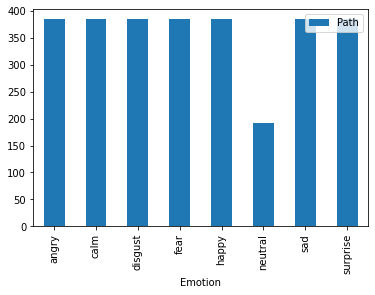

In [4]:
data_df.groupby(['Emotion']).count().plot(kind='bar')

In [5]:
def create_waveplot(data, sr, e=None):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectogram(data, sr, e):
    #stft function converts data to short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
    plt.colorbar()

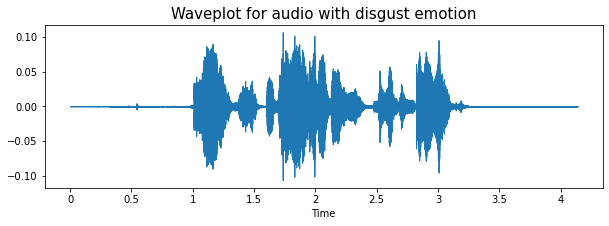

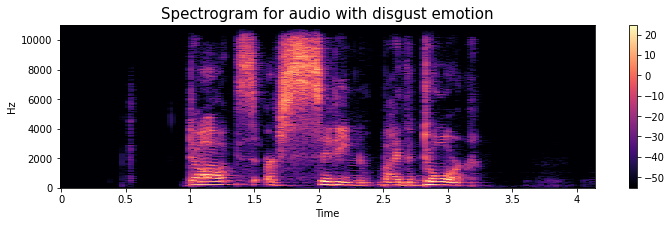

In [6]:
# Waveplots - Waveplots let us know the loudness of the audio at a given time.
emotion = 'disgust'
path = np.array(data_df.Path[data_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...


In [7]:
def add_noise(data):
    noise_amp = 0.35*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data


In [8]:
path = np.array(data_df.Path)[66]
data, sample_rate = librosa.load(path)

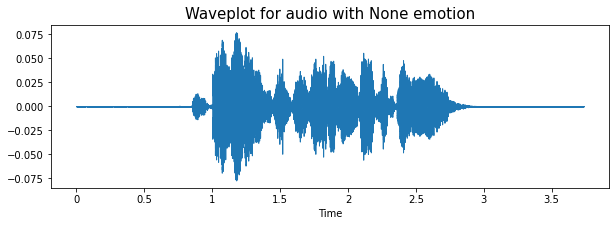

In [9]:
# 1. Simple audio
create_waveplot(data, sample_rate)
Audio(path)